# 2D MT Inversion: MSE vs OT (1 Anomaly, 1% Noise)

**What this notebook does:** Runs 2D MT inversion on synthetic data (one conductive anomaly) using two data misfit options:
- **MSE (Mean Squared Error):** Standard L2 data loss.
- **OT (Optimal Transport):** Sinkhorn OT-based data loss with weighted cost.

**Effect:** Compare resistivity sections (true vs inverted) and data fitting between MSE and OT approaches.

## 1. Setup: Imports, Device, Grid & Model (Shared)

In [1]:
import sys
import os

# Ensure repo root is on path (works when run from tests/test_mt2d or repo root)
for _root in [os.getcwd(), os.path.join(os.getcwd(), ".."), os.path.join(os.getcwd(), "..", "..")]:
    if os.path.exists(os.path.join(_root, "src", "mt2d_inv")):
        if _root not in sys.path:
            sys.path.insert(0, _root)
        break

import torch
import numpy as np
import matplotlib.pyplot as plt
from src.mt2d_inv import MT2DInverter, MT2DInverterWeightedCost, MT2DTrueModels

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {device}")

# Frequencies and stations (shared)
freqs = torch.logspace(0.5, -4, 20)
stations = torch.linspace(-15000, 15000, 31)

# Grid and true model (single anomaly: |Y|<3km, 5km<Z<10km, 1 S/m)
model = MT2DTrueModels()
yn, zn, nza, sig_true = model.create_single_anomaly(device=device)

print(f"Grid: {len(zn)-1} x {len(yn)-1} cells")
print(f"  First layer thickness: {zn[nza+1] - zn[nza]:.1f} m")
print(f"  Max depth: {zn[-1]/1000:.1f} km")

Running on cuda
Grid: 40 x 40 cells
  First layer thickness: 100.0 m
  Max depth: 100.0 km


## 2. MSE Inversion

✓ Random seed set: 123
✓ 创建Sinkhorn损失:
  - p: 2, blur: 0.01, scaling: 0.9, diameter: 2.0
  - reach: None (平衡/强约束)
✓ Sinkhorn OT Loss initialized: p=2, blur=0.01, scale=0.9, reach=None, backend=tensorized
Generating 2D MT synthetic data...
✓ XY mode error propagation completed
   rho(log10) noise mean: 0.0261
   phi(normalized) noise mean: 0.0191
✓ YX mode error propagation completed
   rho(log10) noise mean: 0.0261
   phi(normalized) noise mean: 0.0191
✓ 2D data error propagation completed
Computing data weights (Target Noise: 3.0%)
  - Resistivity Error Floor: 3.0%
  - Phase Error Floor:       0.858 deg
✓ Synthetic data generated
  -> Impedance noise level: 3.0% (gaussian)
✓ Model initialization complete: Uniform.
  - Air layer fixed: nza=10, air_sigma=1.00e-10 S/m


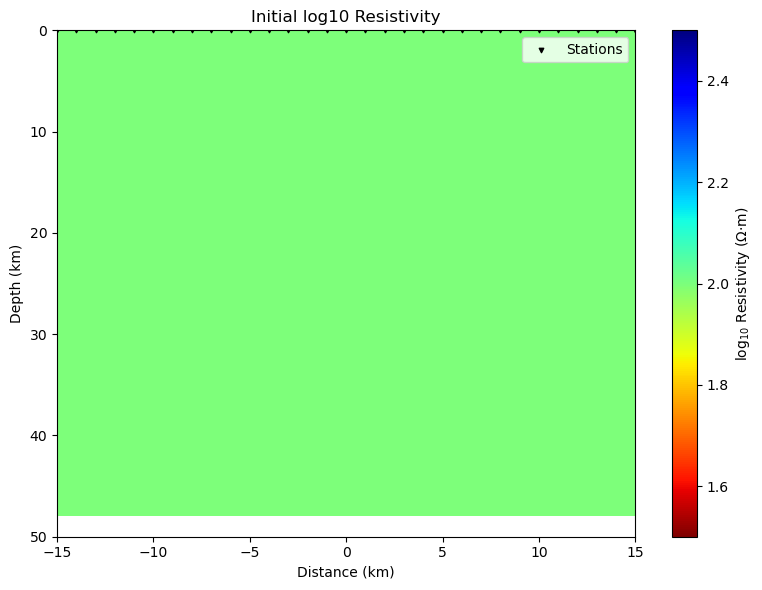

In [2]:
# Create MSE inverter
inverter_mse = MT2DInverter(
    nza=nza,
    yn=torch.tensor(yn, device=device),
    zn=torch.tensor(zn, device=device),
    freqs=freqs.to(device),
    stations=stations.to(device),
    device=device,
    random_seed=123,
    ot_options={"reach": None},
)
inverter_mse.set_forward_operator()

# Set true model and generate synthetic data (3% noise)
inverter_mse.sig_true = sig_true
inverter_mse.create_synthetic_data(noise_level=0.03)

# Initialize inversion model
inverter_mse.initialize_model(initial_sigma=0.01)
inverter_mse.plot_initial_model()

In [3]:
# Run MSE inversion
final_sigma_mse = inverter_mse.run_inversion(
    n_epochs=1000,
    mode="mse",
    progress_interval=100,
    current_lambda=10,
    use_adaptive_lambda=True,
    lr=0.05,
    update_interval=10,
    norm_type="L2",
    alpha=0.5,
    use_depth_weights=True,
    rms_chi2_stop=1.05,
)
print("MSE inversion completed.")

✓ 创建优化器: AdamW
  - 学习率: 0.05
  - 权重衰减: 0.0
Epoch 1/1000 [   0.1%]
  Elapsed: 0:00:03 | Remaining: ~0:42:26 | ETA: 02:03:14
  Epoch time: 2.55s | Avg: 2.55s
  Total: 5.1681e+01 | Data(mse): 5.1681e+01
  Misfit(RMS χ²): 7.189 | Rough: 0.00e+00 | Lam: 10.0000000
  GradNorms: |g_d|=1.296e-01 | |g_m|=1.000e-12
Epoch 101/1000 [  10.1%]
  Elapsed: 0:04:52 | Remaining: ~0:43:11 | ETA: 02:08:48
  Epoch time: 2.68s | Avg: 2.88s
  Total: 2.2069e+00 | Data(mse): 1.7769e+00
  Misfit(RMS χ²): 1.333 | Rough: 4.30e-02 | Lam: 10.0000000
  GradNorms: |g_d|=6.122e-03 | |g_m|=2.014e-04
 [Auto-Lambda] Epoch 120: Adjusted 1.00e+01 -> 9.44e+00
 [Auto-Lambda] Epoch 130: Adjusted 9.44e+00 -> 8.43e+00
  [Early stop] RMS χ² = 1.049 < 1.05, epoch = 141
Inversion completed.
MSE inversion completed.


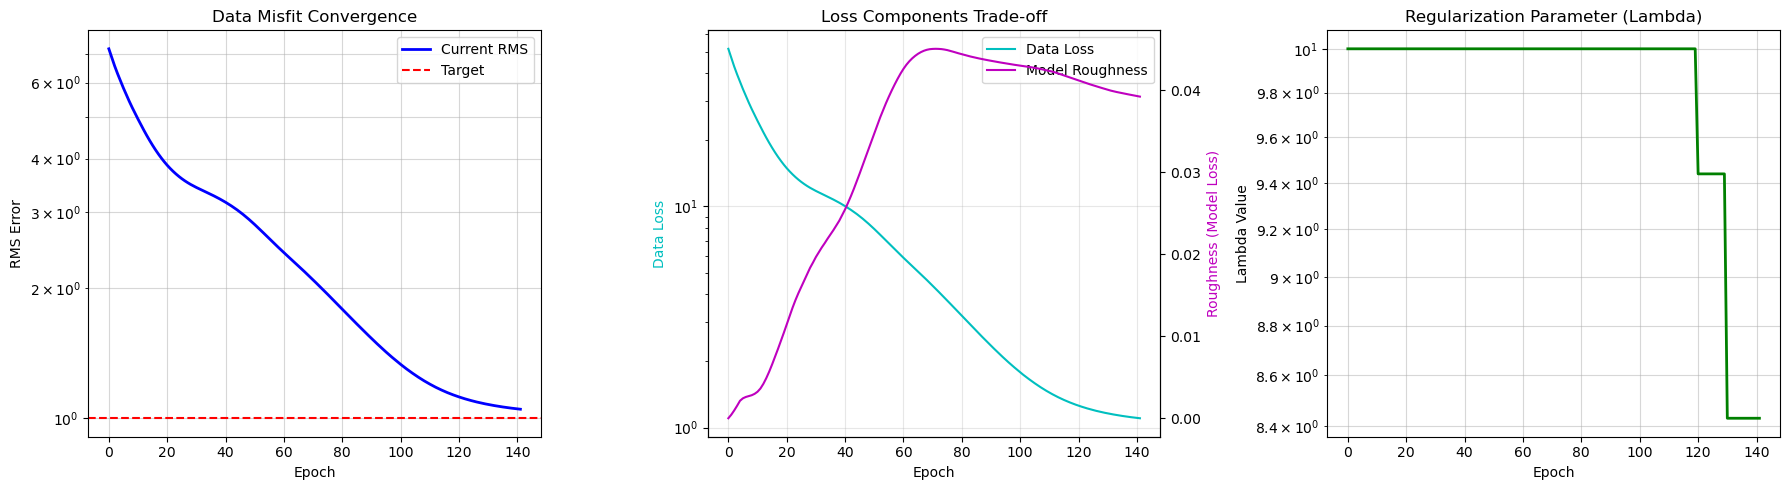

Model structural similarity (SSIM): 0.8951


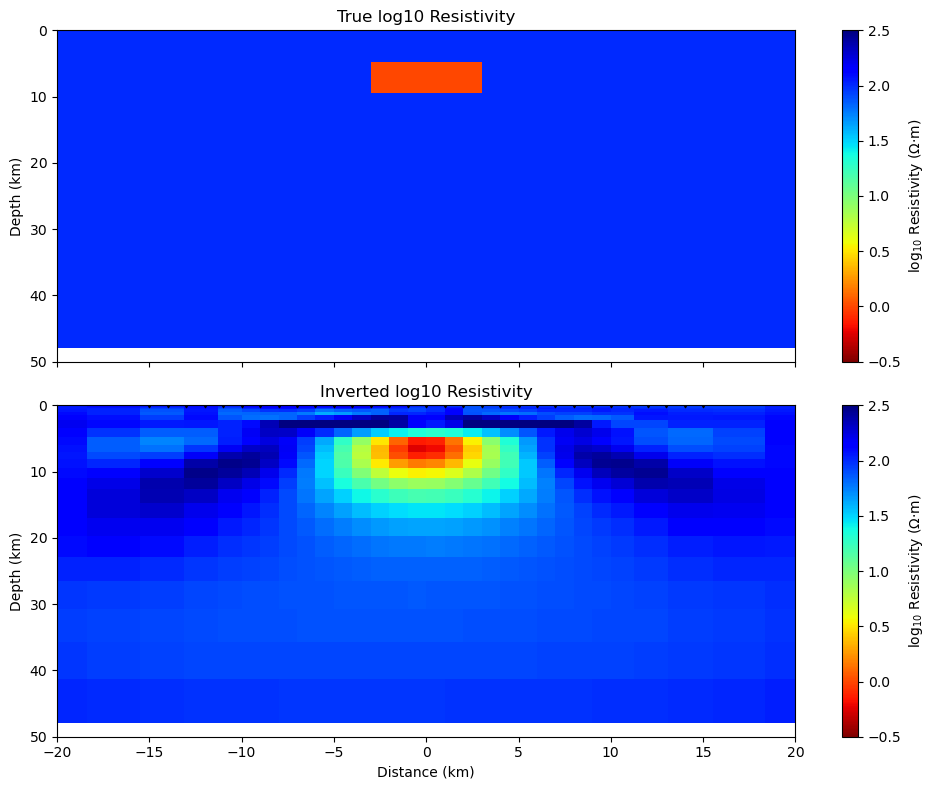

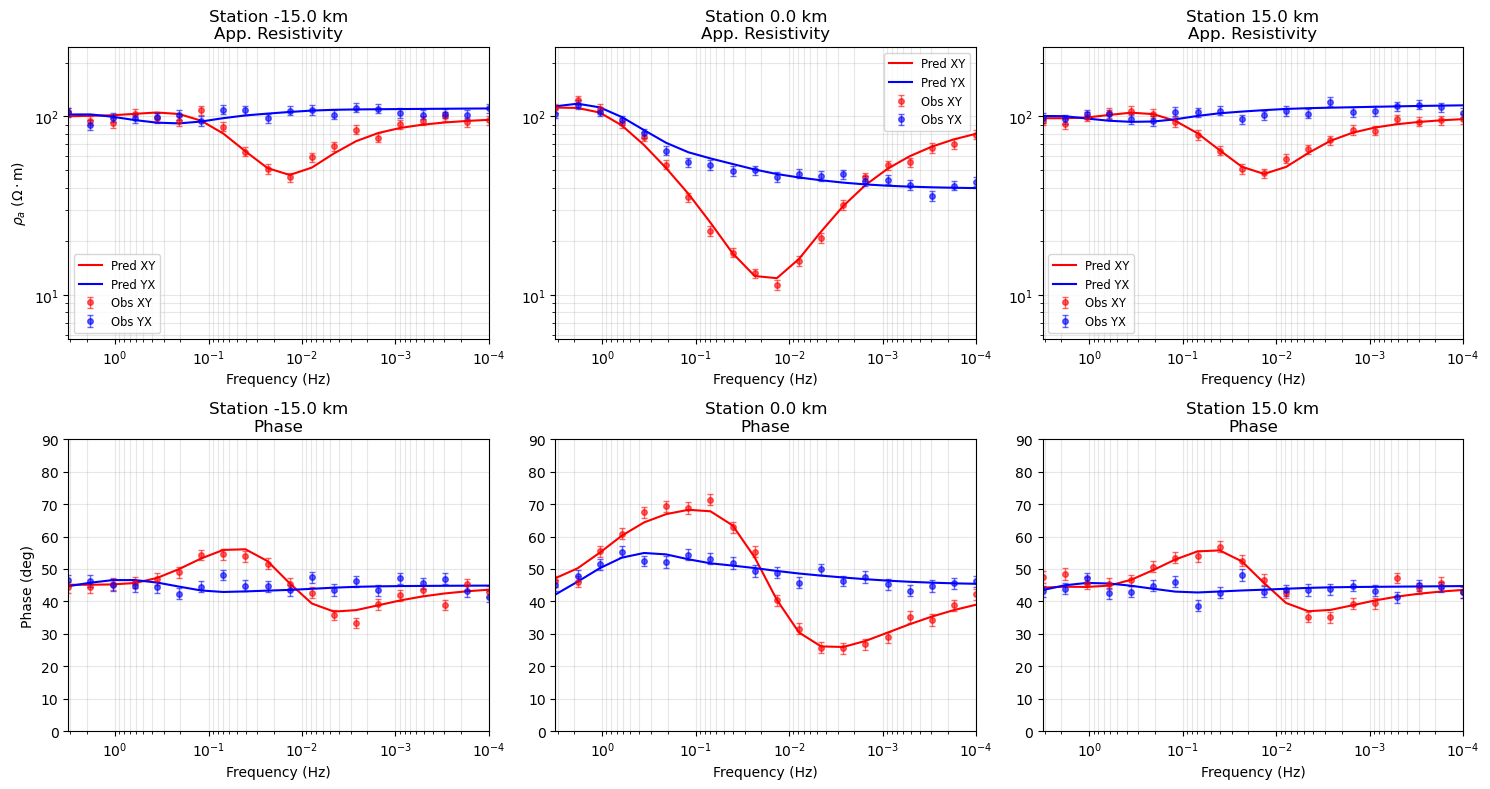

In [4]:
# MSE output
inverter_mse.plot_loss_history()
inverter_mse.plot_model_comparison(cmap="jet_r", xlim=[-20, 20], ylim=[50, 0])
inverter_mse.plot_data_fitting()

## 3. OT Inversion (Sinkhorn Weighted Cost)

✓ Random seed set: 123
✓ 创建Sinkhorn损失 (自定义 cost): blur=0.01, scaling=0.9
✓ Sinkhorn OT Loss (加权成本): w_s=1.0, w_f=1.0, w_d=10, blur=0.01, scale=0.9, reach=0.05
Generating 2D MT synthetic data...
✓ XY mode error propagation completed
   rho(log10) noise mean: 0.0087
   phi(normalized) noise mean: 0.0064
✓ YX mode error propagation completed
   rho(log10) noise mean: 0.0087
   phi(normalized) noise mean: 0.0064
✓ 2D data error propagation completed
Computing data weights (Target Noise: 1.0%)
  - Resistivity Error Floor: 1.0%
  - Phase Error Floor:       0.500 deg
✓ Synthetic data generated
  -> Impedance noise level: 1.0% (gaussian)
✓ Model initialization complete: Uniform.
  - Air layer fixed: nza=10, air_sigma=1.00e-10 S/m

OT 各维度贡献诊断 E[(Δx_k)²]
  k=0 freq(norm)      : E[(Δx_k)²] = 0.000000e+00
         pred 范围 [0.0000, 1.0000]  obs 范围 [0.0000, 1.0000]
  k=1 station(norm)   : E[(Δx_k)²] = 0.000000e+00
         pred 范围 [0.0000, 1.0000]  obs 范围 [0.0000, 1.0000]
  k=2 rhoxy           : E[(

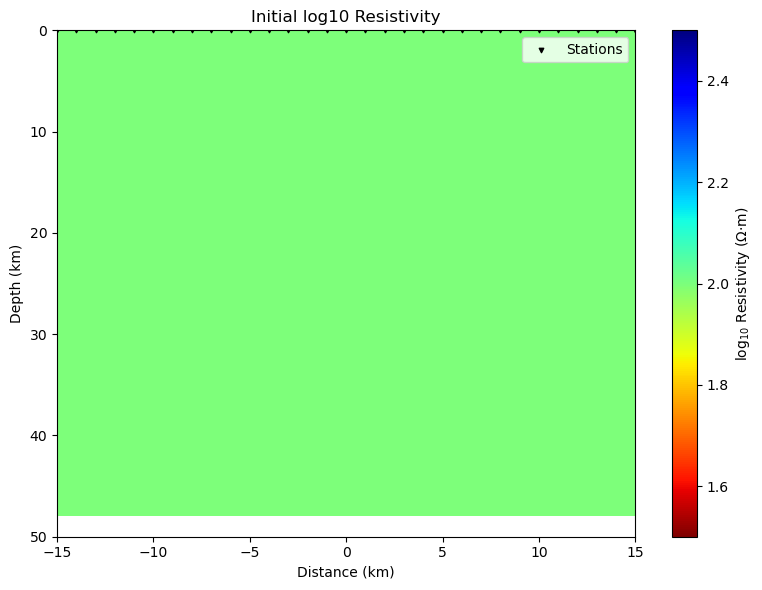

In [5]:
# Create OT inverter (Sinkhorn with weighted cost)
inverter_ot = MT2DInverterWeightedCost(
    nza=nza,
    yn=torch.tensor(yn, device=device),
    zn=torch.tensor(zn, device=device),
    freqs=freqs.to(device),
    stations=stations.to(device),
    device=device,
    random_seed=123,
    ot_options={
        "w_s": 1.0,
        "w_f": 1.0,
        "w_d": 10,
        "blur": 0.01,
        "reach": 0.05
    }
)
inverter_ot.set_forward_operator()

# Set true model and generate synthetic data (1% noise)
inverter_ot.sig_true = sig_true
inverter_ot.create_synthetic_data(noise_level=0.01)

# Initialize inversion model
inverter_ot.initialize_model(initial_sigma=0.01)
inverter_ot.print_ot_dimension_contributions()
inverter_ot.plot_initial_model()

In [6]:
# Run OT inversion
final_sigma_ot = inverter_ot.run_inversion(
    n_epochs=1000,
    mode="6dot",
    progress_interval=10,
    current_lambda=100,
    use_adaptive_lambda=True,
    lr=0.05,
    update_interval=10,
    norm_type="L2",
    alpha=0.5,
    use_depth_weights=True,
    rms_chi2_stop=1.05,
)
print("OT inversion completed.")
print("Final model range:", final_sigma_ot.min().item(), final_sigma_ot.max().item())

✓ 创建优化器: AdamW
  - 学习率: 0.05
  - 权重衰减: 0.0
Epoch 1/1000 [   0.1%]
  Elapsed: 0:00:02 | Remaining: ~0:43:43 | ETA: 02:11:23
  Epoch time: 2.63s | Avg: 2.63s
  Total: 2.4058e+00 | Data(6dot): 2.4058e+00
  Misfit(RMS χ²): 21.388 | Rough: 0.00e+00 | Lam: 100.0000000
  GradNorms: |g_d|=6.518e-03 | |g_m|=1.000e-12
Epoch 11/1000 [   1.1%]
  Elapsed: 0:00:30 | Remaining: ~0:46:18 | ETA: 02:14:27
  Epoch time: 3.01s | Avg: 2.81s
  Total: 2.4780e+00 | Data(6dot): 2.2457e+00
  Misfit(RMS χ²): 18.313 | Rough: 2.32e-03 | Lam: 100.0000000
  GradNorms: |g_d|=2.874e-03 | |g_m|=4.129e-04
Epoch 21/1000 [   2.1%]
  Elapsed: 0:00:58 | Remaining: ~0:45:34 | ETA: 02:14:10
  Epoch time: 2.68s | Avg: 2.79s
  Total: 2.3039e+00 | Data(6dot): 2.2166e+00
  Misfit(RMS χ²): 17.560 | Rough: 8.73e-04 | Lam: 100.0000000
  GradNorms: |g_d|=1.361e-03 | |g_m|=1.487e-04
Epoch 31/1000 [   3.1%]
  Elapsed: 0:01:26 | Remaining: ~0:45:13 | ETA: 02:14:18
  Epoch time: 2.63s | Avg: 2.80s
  Total: 2.2718e+00 | Data(6dot): 2.1854

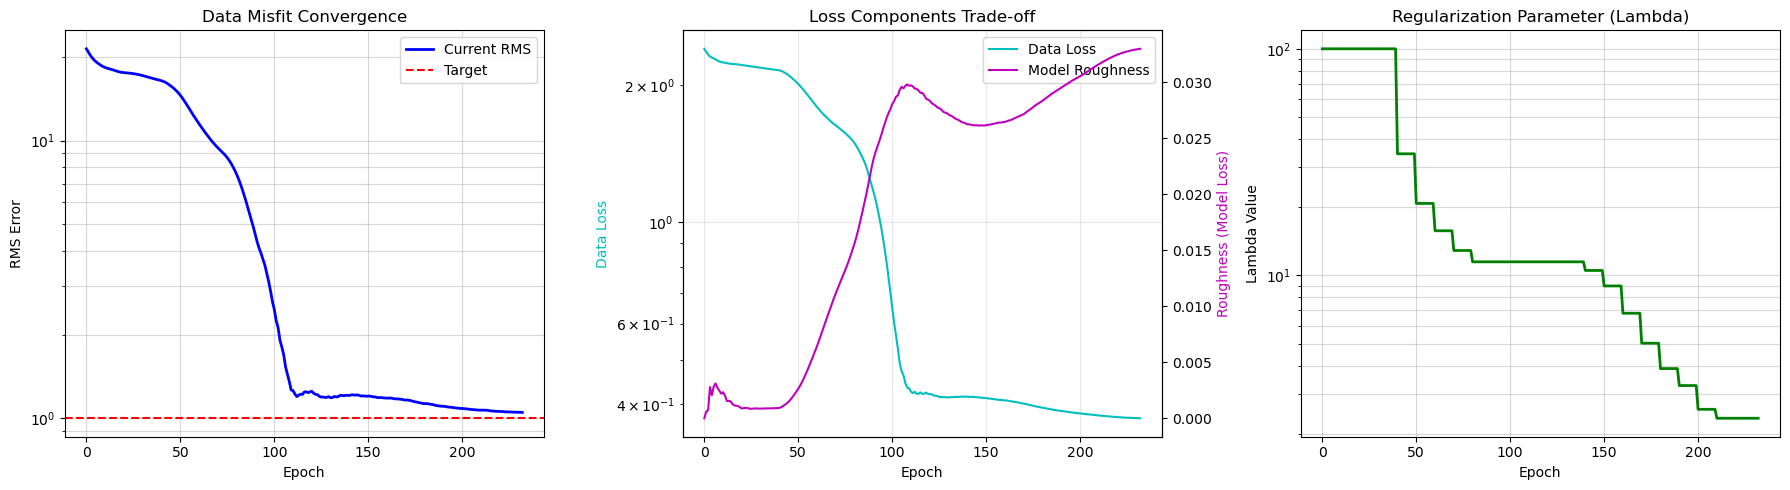

Model structural similarity (SSIM): 0.9596


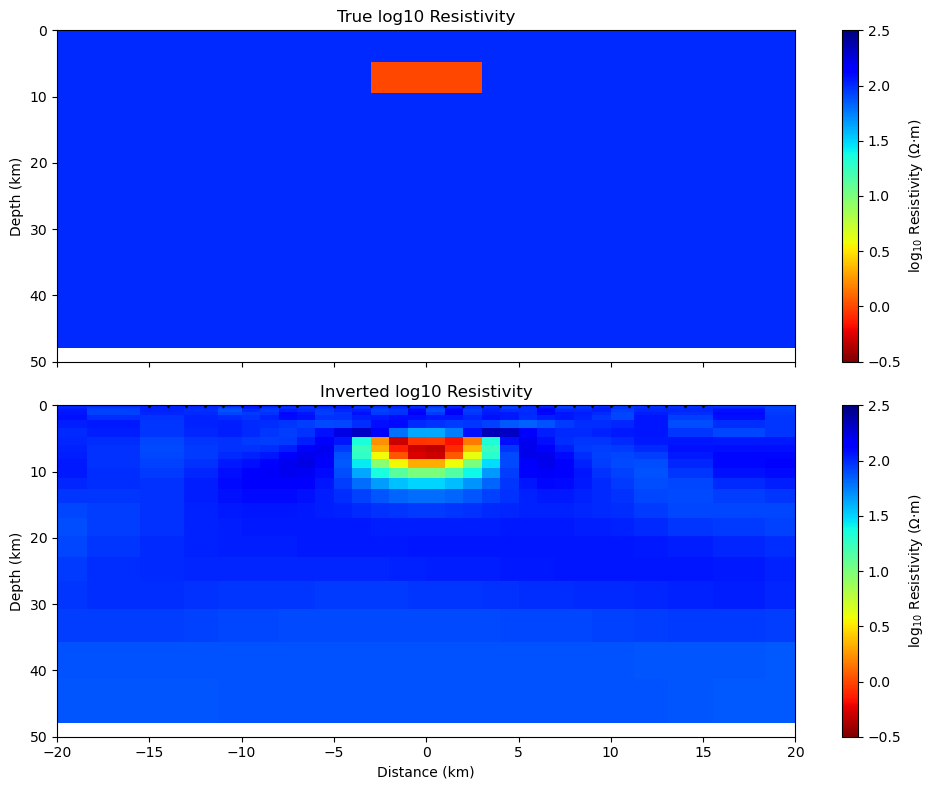

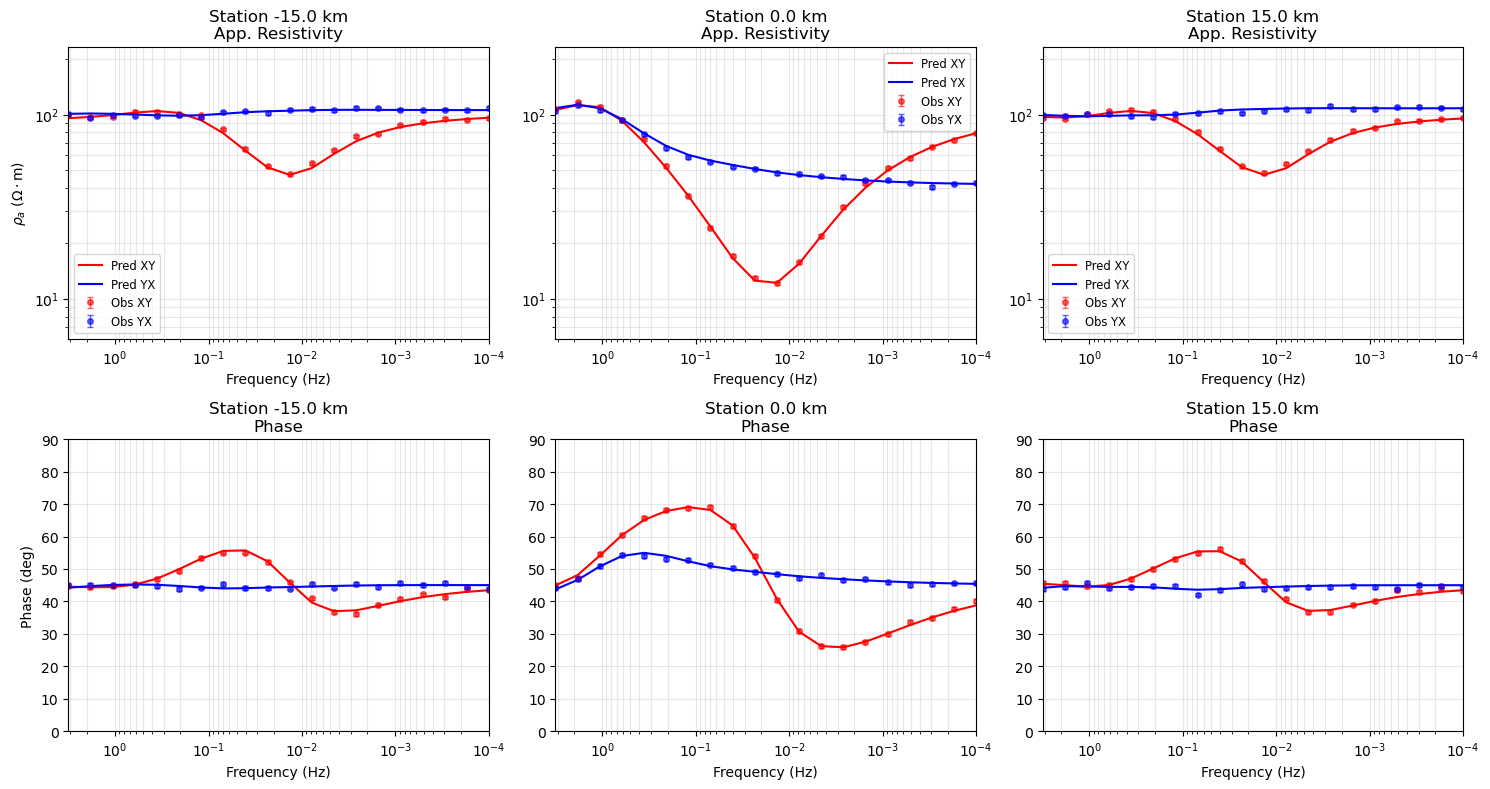

In [7]:
# OT output
inverter_ot.plot_loss_history()
inverter_ot.plot_model_comparison(cmap="jet_r", xlim=[-20, 20], ylim=[50, 0])
inverter_ot.plot_data_fitting()
